# Importando os datasets e extraindo os sinais de áudio

In [0]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path

In [0]:
dcase_data = pd.read_csv('/content/drive/My Drive/DCASE/Datasets/file_label_dcase.csv')
urls_indoor = (dcase_data.loc[dcase_data['label'] == 'indoor'])['file']
urls_transp = (dcase_data.loc[dcase_data['label'] == 'transportation'])['file']
urls_outdoor = (dcase_data.loc[dcase_data['label'] == 'outdoor'])['file']
#dcase_data[['label','TAU_file', 'file']]

In [27]:
urls_indoor = ['https://zenodo.org/record/3670185/files/TAU-urban-acoustic-scenes-2020-3class-development.audio.1.zip?download=1']
urls_outdoor = ['https://zenodo.org/record/3670185/files/TAU-urban-acoustic-scenes-2020-3class-development.audio.16.zip?download=1']
urls_transp = ['https://zenodo.org/record/3670185/files/TAU-urban-acoustic-scenes-2020-3class-development.audio.21.zip?download=1']

def get_datasets(urls, label):
    for i, url in enumerate(urls):
        dirname = '/content/drive/My\ Drive/DCASE/Datasets/{}'.format(label)
        filename = dirname + '/dataset{}.zip'.format(i+1)
        # Não podemos usar filename por causa de   'My\  '
        if not (path.isfile('/content/drive/My Drive/DCASE/Datasets/{0}/dataset{1}.zip'.format(label, i+1))):
            !wget -O $filename $url
            !unzip $filename -d $dirname
            print('Im goind to download it')
        else:
            print('This dataset already exists')
        break

get_datasets([urls_indoor[0]], 'Indoor')
get_datasets([urls_outdoor[0]], 'Outdoor')
get_datasets([urls_transp[0]], 'Transportation')


This dataset already exists
This dataset already exists
This dataset already exists


In [0]:
def import_signal(path):
    s, sr = librosa.core.load(path)
    return s

In [0]:
signals = []
labels = ['Indoor', 'Outdoor', 'Transportation']
rotulos = []

for dirname, _, filenames in os.walk('/content/drive/My Drive/DCASE/Datasets/'):
    print(filenames)
    for filename in filenames:
        print(dirname)
        label = [labels.index(item) for item in labels if item in dirname]
        rotulos.append(label)
        print(label)
        break
        if not(filename.endswith('.zip')):
            #signals.append(import_signal(os.path.join(dirname, filename)))
            print('')


signals = np.asarray(signals)
rotulos = np.asarray(rotulos)
rotulos

In [64]:
labels = ['Indoor', 'Outdoor', 'Transportation']
rotulos = []
signals = []
dic_signals = {x:[] for i, x in enumerate(labels)}
for l in labels:
    for dirname, _, filenames in os.walk('/content/drive/My Drive/DCASE/Datasets/{}/TAU-urban-acoustic-scenes-2020-3class-development/audio'.format(l)):
        for filename in filenames:
            index_label = [labels.index(item) for item in labels if item == l]
            rotulos.append(index_label[0])
            #dic_signals[l].append(index_label[0])
            
            signals.append(import_signal(os.path.join(dirname, filename)))

print(dic_signals)
signals[0]


{'Indoor': [], 'Outdoor': [], 'Transportation': []}


array([1.1129333e-04, 1.0265002e-04, 1.6707958e-04, ..., 4.1840909e-04,
       1.0353265e-04, 8.1137077e-05], dtype=float32)

# Transformada de Fourier de Curto Termo



hop_length : int > 0 [scalar] - Usamos 1024

number of audio samples between adjacent STFT columns.



In [65]:
def stft(signal):
    S, phase = librosa.magphase(np.abs(librosa.stft(signal, hop_length=1024)))
    return S

signals_stft = []
for s in signals:
    signals_stft.append(stft(s))

signals_stft = np.asarray(signals_stft)
signals_stft.shape

(1908, 1025, 216)

# Features

In [0]:
def get_features(signals_stft, rotulos):
    def get_centroid(S):
        return librosa.feature.spectral_centroid(S=S)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(s):
        return librosa.feature.rms(s, hop_length=1024)

    info = {'Centroid Mean':[], 
        'Centroid STD': [], 
        'Flatness Mean':[],
        'Flatness STD':[],
        'RMS':[],
        'Target': []} 

    
    for s, rotulo in zip(signals_stft, rotulos):
      
        info['Target'].append(rotulo)
        
        '''
            Obtendo centroide, flatness e RMS
        '''
        c = get_centroid(s)
        c = c[0]
        info['Centroid Mean'].append(np.mean(c))
        info['Centroid STD'].append(np.std(c))
        
        
        f = get_flatness(s)
        f = f[0]
        info['Flatness Mean'].append(np.mean(f))
        info['Flatness STD'].append(np.std(f))
        
        r = get_rms(s)
        r = round(r[0][0],3)
        info['RMS'].append(r)
        
        
        
    return pd.DataFrame(info)

In [67]:
df = get_features(signals_stft, rotulos)
df

,Centroid Mean,Centroid STD,Flatness Mean,Flatness STD,RMS,Target
0,1311.587505,349.229682,0.005359,0.016700,0.020,0
1,1370.193362,181.338495,0.004279,0.002370,0.019,0
2,1230.777107,425.217370,0.002626,0.004523,0.067,0
3,1284.568483,227.035107,0.003137,0.002076,0.013,0
4,1311.171146,334.136622,0.003794,0.004549,0.014,0
...,...,...,...,...,...,...
1903,770.032984,256.379436,0.000606,0.000881,0.053,2
1904,631.429167,159.158612,0.000209,0.000184,0.120,2
1905,937.230123,147.032409,0.000984,0.000782,0.107,2
1906,1129.394562,492.638637,0.002124,0.003796,0.030,2


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()

X,y = df.iloc[:,0:-1], df['Target'].values
scaler.fit(X)
X = scaler.transform(X)

In [71]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[0])
print(y_train[0])

[-0.14669776 -0.59248703 -0.43127102 -0.47892557 -0.51402328]
0


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [0]:
def knn_classifier(X_train, X_test, y_train, k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    return [y_pred, metrics.accuracy_score(y_test,y_pred)]

def get_k_accuracy(X_train, X_test, y_train, y_test): 

    def plot_scores(x,y):
        fig, a = plt.subplots(1, figsize = (10, 8))
        title = "Accuracy Score by K values"
        plt.title(title)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        a.plot(x, y)

    k_range = range(1,31)
    scores = {}
    scores_list = []

    for k in k_range:
        y_pred, scores[k] = knn_classifier(X_train, X_test, y_train, k)
        scores_list.append(scores[k])

    plot_scores(list(k_range), scores_list)
    print('Accuracy: ' + str(scores[max(scores, key= scores.get)]))
    return max(scores, key= scores.get)



Accuracy: 0.7277486910994765


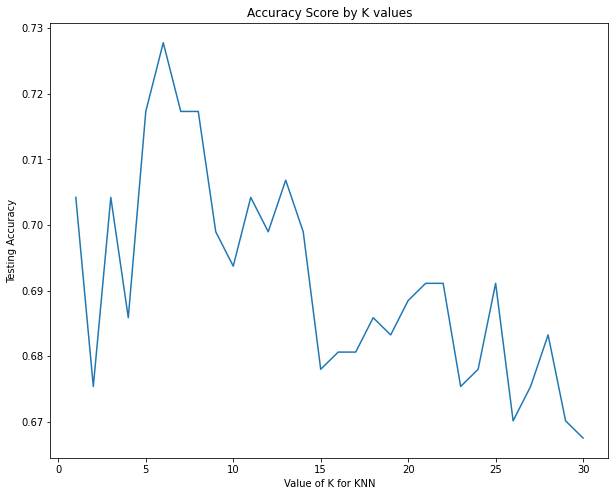

In [127]:
k = get_k_accuracy(X_train,X_test, y_train, y_test)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

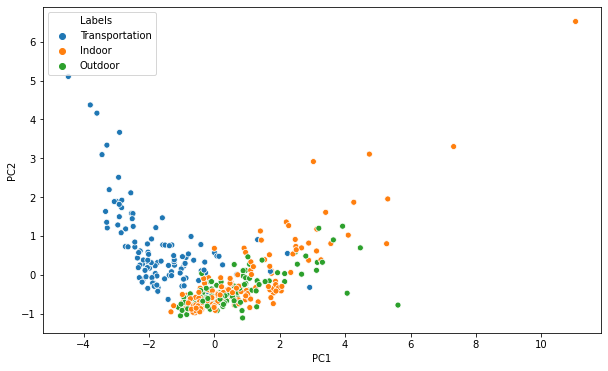

In [76]:
from sklearn.decomposition import PCA
import seaborn as sns

pca1 = PCA(2)
trans_pca1 = pca1.fit_transform(X_test)
trans_pca1 = pd.DataFrame(trans_pca1)
trans_pca1['Labels'] = [l for y in y_test for i, l in enumerate(labels) if y==i]
trans_pca1.columns = ['PC1', 'PC2', 'Labels']
trans_pca1.head()
plt.figure(figsize=(10,6))
sns.scatterplot(x=trans_pca1['PC1'], y=trans_pca1['PC2'], hue=trans_pca1['Labels'])

Accuracy: 0.6701570680628273


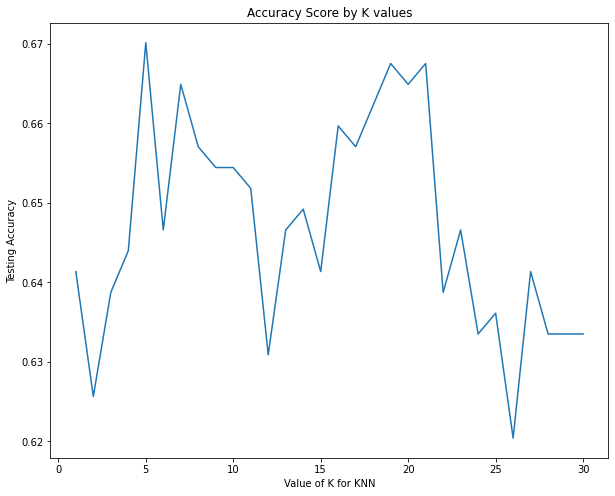

In [128]:
pca2 = PCA(2)
X_train_trans = pca2.fit_transform(X_train)
X_test_trans = pca2.transform(X_test)

k = get_k_accuracy(X_train_trans,X_test_trans, y_train, y_test)

